<a href="https://colab.research.google.com/github/kimhj010502/ESAA_OB/blob/main/WEEK15_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b> [파이썬 딥러닝 텐서플로] </b> <br>
## Chapter 04 합성곱 신경망 (CNN)

## 4.4 위성 이미지 분류

### 4-1 텐서플로 데이터셋 로드 <br>
- 총 27000장의 위성 사진과 10개의 토지이용분류 값이 매칭되어 있는 공용 데이터셋

In [1]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pylab as plt

#Tensorflow Datasets 활용
import tensorflow_datasets as tfds

In [10]:
#EuroSAT 위성 사진 데이터셋 로드

DATA_DIR = '/content/dataset/'

(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                       shuffle_files=True,
                                       as_supervised=True, #tuple 형태로 데이터 반환환
                                       with_info=True, #메타 정보 반환 여부부
                                       data_dir=DATA_DIR)
print(train_ds)
print(valid_ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling /content/dataset/eurosat/rgb/2.0.0.incomplete0YEJR8/eurosat-train.tfrecord*...:   0%|          | 0/2…

Dataset eurosat downloaded and prepared to /content/dataset/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
<PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [11]:
#메타 데이터 확인
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path='/content/dataset/eurosat/rgb/2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervise

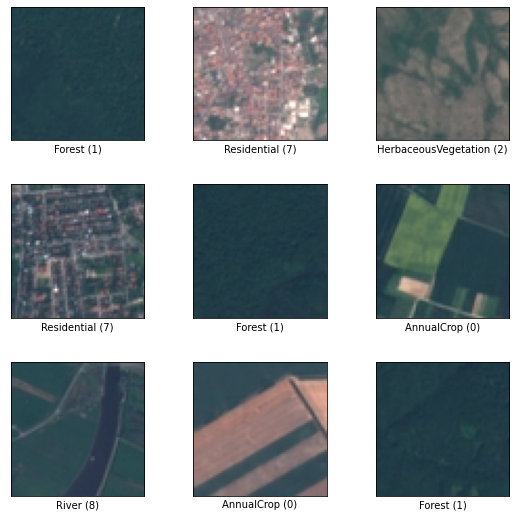

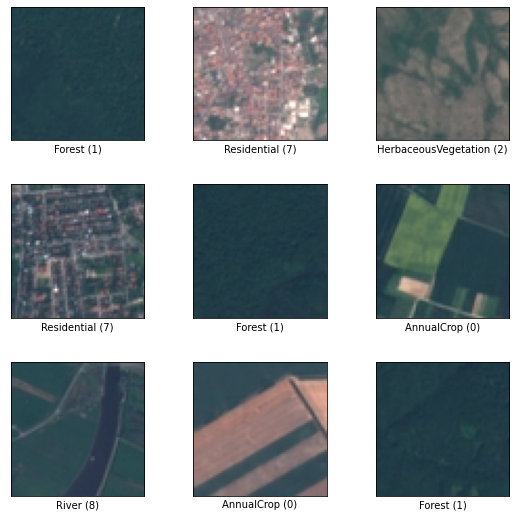

In [12]:
#데이터 확인
tfds.show_examples(train_ds, info)

image  label
0  [[[56, 84, 121], [56, 85, 119], [67, 94, 124],...      5
1  [[[102, 105, 112], [105, 104, 110], [116, 107,...      7
2  [[[82, 98, 97], [83, 97, 97], [86, 97, 99], [9...      0
3  [[[56, 72, 87], [56, 72, 87], [52, 70, 82], [5...      1
4  [[[219, 154, 126], [218, 153, 125], [220, 154,...      0
5  [[[69, 83, 84], [67, 83, 83], [65, 80, 85], [6...      2
6  [[[28, 52, 76], [28, 52, 76], [31, 51, 75], [3...      9
7  [[[45, 75, 77], [46, 74, 78], [49, 69, 78], [6...      8
8  [[[135, 127, 124], [135, 127, 124], [132, 127,...      2
9  [[[40, 55, 74], [40, 55, 74], [41, 56, 75], [3...      9
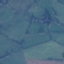
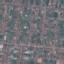
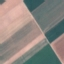
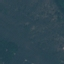
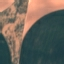
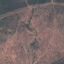
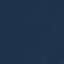
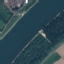
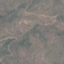
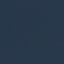

In [13]:
#as_dataframe 사용하여 샘플 출력
tfds.as_dataframe(valid_ds.take(10), info)

In [14]:
#목표 클래스의 개수
NUM_CLASSES = info.features['label'].num_classes
print(NUM_CLASSES)

10


In [15]:
#숫자 레이블을 활용해 문자열 메타 데이터로 변환
print(info.features['label'].int2str(6))

PermanentCrop


### 4-2 데이터 전처리 <br>
- 텐서플로는 데이터 전처리에 필요한 함수들을 제공하고 있을 뿐만 아니라, 텐서 연산을 효율적으로 처리할 수 있는 최적화를 지원함
<br><br>
- 텐서플로 연산은 float32 숫자 값을 사용하기 때문에, cast 함수를 사용하여 자료형을 float32로 변환해줌
- 입력 이미지는 0~255 범위의 픽셀 값을 갖기 때문에, 255로 나눠서 정규화함
- 이 과정을 처리하는 `preprocess_data` 함수를 정의함
<br><br>
- `map` 함수는 사용자 정의 함수를 매핑하여 텐서플로 데이터셋에 적용하는 메소드로 전처리 과정에서 매우 유용함
- `num_parallel_calls` 옵션을 오토튠(AUTOTUNE)으로 지정하면 텐서플로 병렬연산 처리를 자동으로 최적화함
<br><br>
- 오토튠을 적용하지 않으면 데이터를 읽어서 매핑하고 훈련하는 과정을 순차적으로 처리하기 때문에 시간이 오래걸림
- 반면 오토튠을 적용하면 하드웨어 리소스를 병렬로 매핑하여 처리하기 때문에 같은 작업을 훨씬 짧은 시간에 처리할 수 있게 됨
<br><a href='https://ifh.cc/v-mVd4nB' target='_blank'><img src='https://ifh.cc/g/mVd4nB.jpg' border='0'></a>
<br><br>
- 정규화 변환을 마친 데이터셋에 `shuffle()` 메소드를 적용하면 순서를 랜덤하게 섞어 줌
- 모델의 일반화된 성능을 높이기 위해 훈련 데이터셋에서 미니 배치를 생성할 때 입력 순서에 무작위성을 부여하는 개념임
- BUFFER_SIZE를 1000으로 지정하고 BATCH_SIZE를 64로 지정했는데, 처음 1000개의 데이터를 가져와서 섞고, 여기에 64개의 데이터를 랜덤하게 선택해서 하나의 배치를 구성함
- 이때 64개가 추출되어 미니 배치를 구성하고 학습에 사용되면, 다시 64개의 데이터가 버퍼(buffer)에 추가되어 항상 1000개의 버퍼를 구성함
<br><br>
- `prefetch()` 메소드는 모델이 훈련을 진행하는 동안 다음에 입력할 데이터를 불러와서 미리 전처리하도록 시스템을 조율하며 병렬 처리를 통해 모델 훈련 시간을 단축시켜 줌


In [16]:
#데이터 전처리 파이프라인
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255. #0~1 정규화, float32 변환
    return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

- `shuffle` 함수의 주요 파라미터인 buffer_size의 경우 데이터셋의 크기가 작은 경우 전체 데이터셋의 개수만큼 지정해 주는 것이 무작위성을 확보하는 데 유리함
- 하지만 데이터셋 개수가 많거나 이미지 파일의 크기가 커서 시스템상의 메모리에 전부 올릴 수 없는 경우에는 buffer_size를 1000으로 지정해 주는 것이 일반적임
- 모델의 가중치를 학습하는 데 사용되는 훈련 데이터셋의 순서를 랜덤하게 섞을 필요가 있지만, 검증 데이터셋은 평가 목적에 활용되기 때문에 shuffle 함수를 사용할 필요가 없음
- 데이터셋이 메모리에 모두 들어갈 수 있을 정도로 작다면 RAM에 모두 캐싱할 수 있는 `cache()` 메서드를 사용하면 훈련 속도를 크게 높일 수 있음


### 4-3 모델 훈련 및 검증

In [17]:
#Sequential API를 사용하여 샘플 모델 생성

def build_model():
    
    model = tf.keras.Sequential([

        #Convolution 층
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),

        #Classifier 출력층
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

model = build_model()

In [19]:
#모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#모델 훈련
history = model.fit(train_data, validation_data=valid_data, epochs=10)

Epoch 1/10
338/338 [==============================] - 184s 542ms/step - loss: 1.1221 - accuracy: 0.6012 - val_loss: 0.8974 - val_accuracy: 0.6865
Epoch 2/10
338/338 [==============================] - 182s 540ms/step - loss: 0.9616 - accuracy: 0.6584 - val_loss: 0.7464 - val_accuracy: 0.7500
Epoch 3/10
338/338 [==============================] - 183s 543ms/step - loss: 0.8630 - accuracy: 0.6993 - val_loss: 0.6917 - val_accuracy: 0.7602
Epoch 4/10
338/338 [==============================] - 182s 538ms/step - loss: 0.7844 - accuracy: 0.7212 - val_loss: 0.6119 - val_accuracy: 0.7952
Epoch 5/10
338/338 [==============================] - 183s 541ms/step - loss: 0.7197 - accuracy: 0.7504 - val_loss: 0.5634 - val_accuracy: 0.8141
Epoch 6/10
338/338 [==============================] - 182s 539ms/step - loss: 0.6512 - accuracy: 0.7722 - val_loss: 0.5208 - val_accuracy: 0.8341
Epoch 7/10
338/338 [==============================] - 184s 545ms/step - loss: 0.6019 - accuracy: 0.7927 - val_loss: 0.4880 -

- 모델은 10 epoch까지는 빠른 속도로 훈련이 진행되면서 손실함수가 급격하게 감소함
- 하지만 그 이후로는 검증 셋에 대한 손실함수가 더 이상 줄어들지 않으면서 과대적합 경향을 나타냄

In [21]:
#모델의 예측 오차와 정확도를 그래프로 그리는 함수
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    axes[0].plot(range(1, epoch+1), loss, label='Training')
    axes[0].plot(range(1, epoch+1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch+1), acc, label='Training')
    axes[1].plot(range(1, epoch+1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

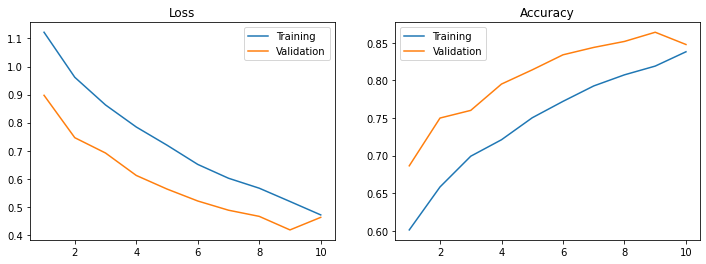

In [22]:
#손실함수, 정확도 그래프 그리기
plot_loss_acc(history, 10)

### 4-4 데이터 증강 (Data Augmentation) <br>
- 과대적합을 해소하는 기법인 배치 정규화, Dropout 등을 적용했음에도 과대적합이 발생함
- 이미지 분류 문제에서 과대적합을 해소하고, 모델의 일반화된 Robust한 성능을 확보하는 기법으로 데이터 증강 (Data Augmentation) 기법이 있음
- 이미지 데이터에 여러 가지 변형을 주어서 훈련 데이터의 다양성을 확보하는 방식으로, 모델이 새로운 데이터에 대한 예측력을 강화하도록 하는 개념임

Text(0.5, 1.0, 'Highway')

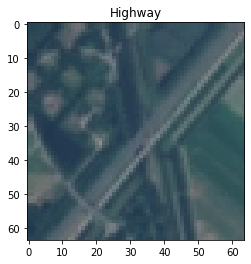

In [37]:
#샘플 이미지
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features['label'].int2str(label))

In [38]:
#데이터 증강 전후를 비교하는 시각화 함수를 정의
def plot_augmentation(original, augmented):

    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    axes[0].imshow(original)
    axes[0].set_title('Original')

    axes[1].imshow(augmented)
    axes[1].set_title('Augmented')

    plt.show()

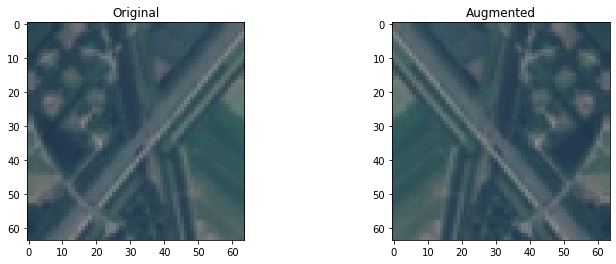

In [39]:
#좌우 뒤집기
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

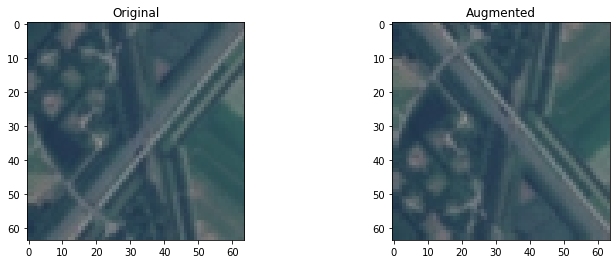

In [40]:
#상하 뒤집기
ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

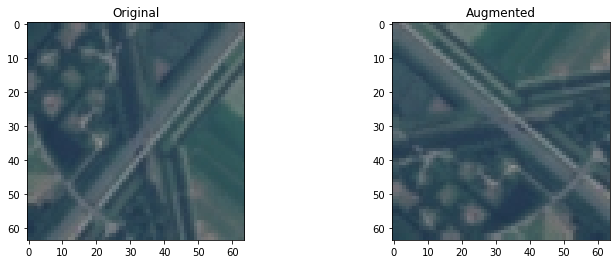

In [41]:
#회전
rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

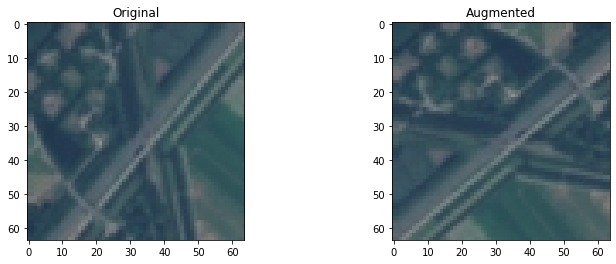

In [42]:
#transpose
transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

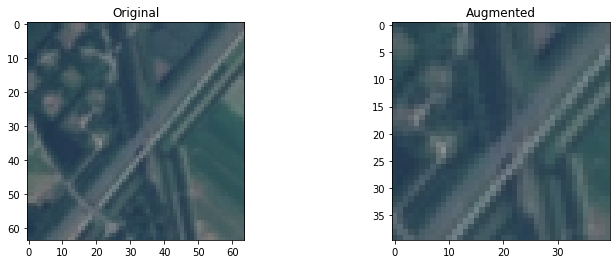

In [43]:
#이미지 자르기 1
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

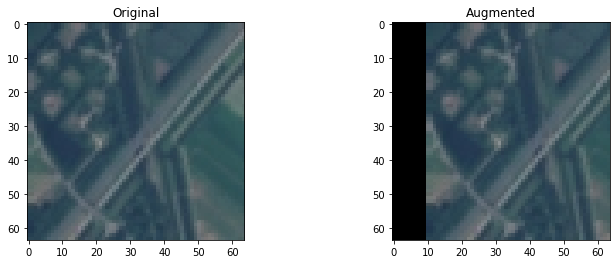

In [44]:
#이미지 자르기 2
img = tf.image.resize_with_crop_or_pad(image, 64 + 20, 64 + 20) #사이즈 키우기
crop2 = tf.image.random_crop(img, size=[64, 64, 3])
plot_augmentation(image, crop2)

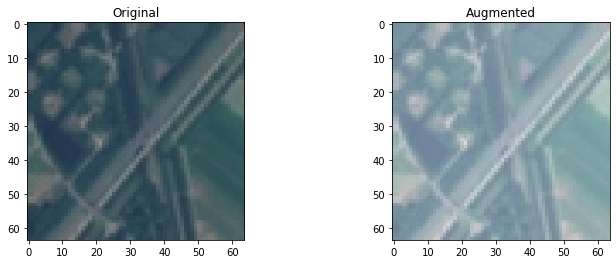

In [45]:
#이미지 밝기
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

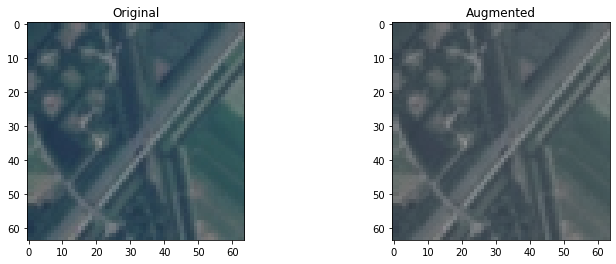

In [46]:
#이미지 채도
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

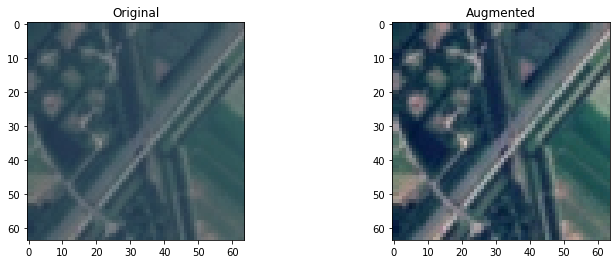

In [47]:
#이미지 대비
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

In [49]:
#이미지 증강 전처리
def data_augmentation(image, label):
    image = tf.image.random_flip_left_right(image) #좌우 반전
    image = tf.image.random_flip_up_down(image) #상하 반전
    image = tf.image.random_brightness(image, max_delta=0.3) #밝기 변화
    image = tf.image.random_crop(image, size=[64, 64, 3])

    image = tf.cast(image, tf.float32) / 255. #0~1 정규화

    return image, label

train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

print(train_aug)
print(valid_aug)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [50]:
#모델 생성
aug_model = build_model()

#모델 컴파일
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#모델 훈련
aug_history = aug_model.fit(train_aug, validation_data=valid_aug, epochs=10)

Epoch 1/10
338/338 [==============================] - 192s 564ms/step - loss: 1.9861 - accuracy: 0.2683 - val_loss: 1.8502 - val_accuracy: 0.3244
Epoch 2/10
338/338 [==============================] - 188s 555ms/step - loss: 1.7173 - accuracy: 0.3405 - val_loss: 1.6426 - val_accuracy: 0.4087
Epoch 3/10
338/338 [==============================] - 187s 554ms/step - loss: 1.5909 - accuracy: 0.3861 - val_loss: 1.3142 - val_accuracy: 0.5389
Epoch 4/10
338/338 [==============================] - 187s 553ms/step - loss: 1.4919 - accuracy: 0.4231 - val_loss: 1.3876 - val_accuracy: 0.4385
Epoch 5/10
338/338 [==============================] - 185s 546ms/step - loss: 1.4602 - accuracy: 0.4375 - val_loss: 1.2539 - val_accuracy: 0.5285
Epoch 6/10
338/338 [==============================] - 184s 545ms/step - loss: 1.3904 - accuracy: 0.4662 - val_loss: 1.2319 - val_accuracy: 0.5335
Epoch 7/10
338/338 [==============================] - 183s 542ms/step - loss: 1.3603 - accuracy: 0.4839 - val_loss: 1.1671 -

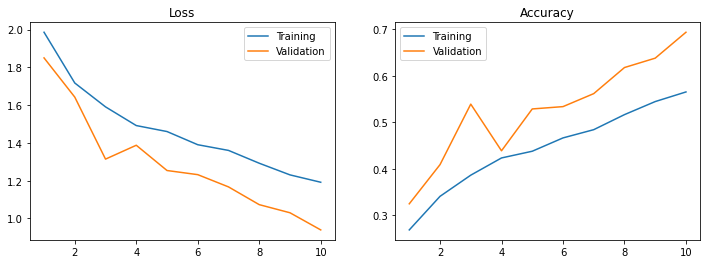

In [51]:
#손실함수, 정확도 그래프 그리기
plot_loss_acc(aug_history, 10)

### 4-5 ResNet 사전 학습 모델 <br>
- ResNet 모델은 이미지넷 경진 대회에서 우승한 모델로서 우수한 성능을 가짐
- 사전에 방대한 이미지로 훈련을 받은 딥러닝 모델의 구조와 가중치를 그대로 가져오고, 모델의 끝단에 위치하는 Top 층에 위성 이미지를 분류할 수 있는 최종 분류기를 추가하는 방식으로 모델을 구성함
- 이런 방식으로 딥러닝 모델을 구성하는 것을 전이 학습 (Transfer Learning)이라고 함
<br><br>
- 케라스에서 모델 인스턴스를 직접 불러올 수 있으며 ResNet50V2 버전을 사용함
- 원래 ResNet 모델의 입력 크기는 (224, 224, 3)이지만, 케라스에서 이미지 크기를 input_shape으로 지정한 크기로 맞춰서 줄여줌
<br><br>
- 가장 중요한 옵션은 `include_top = False`로 지정하는 것임
- 기존 ResNet 모델의 Top층은 이미지넷 경진 대회에 맞는 분류기이므로 False로 지정하며 Top층을 제거해주는 것임
- 제거된 부분에 우리가 해결하려는 문제에 맞는 최종 분류기를 대체해서 추가하면 됨

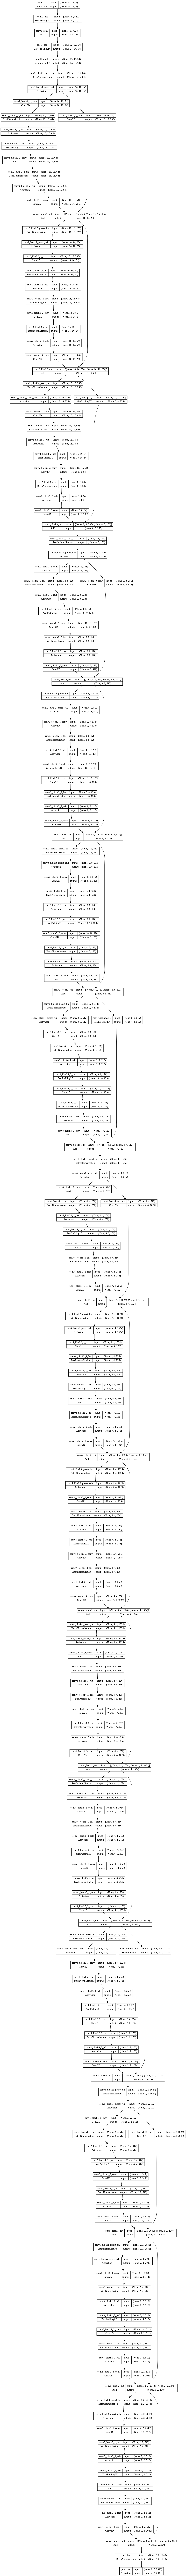

In [55]:
#Pre-trained 모델을 사전 학습된 가중치와 함께 가져오기
from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top=False,
                              weights='imagenet',
                              input_shape=[64, 64, 3])

#사전 학습된 가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable = False

#모델 구조 시각화
from tensorflow.keras.utils import plot_model
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='resnet50.png')

In [56]:
#Top 층에 Classifier 추가

def build_transfer_classifier():

    model = tf.keras.Sequential([

        #Pre-trained Base
        pre_trained_base,
        #Classifier 출력층
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

#모델 구조
tc_model = build_transfer_classifier()
tc_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 10)               

- resnet50v2 모델의 파라미터 23564800개는 훈련이 되지 않으며 (Non-trainable), 우리가 Top 층에 추가한 Dense 레이어들의 파라미터만 가중치가 업데이트됨

## 4.5 개/고양이 분류 <br>
- 실무에서 주로 다루는 이미지 파일은 용량이 크거나 파일 개수가 많아서 컴퓨터 메모리 또는 그래픽 카드 메모리가 부족한 상황이 자주 발생함
- 이런 문제를 해결하려면 이미지 데이터셋을 32장, 64장, 128장 등 배치(batch) 단위로 나눈 다음, 배치 한 개를 읽어와 딥러닝 모델에 주입하면 메모리 부담 없이 학습할 수 있음
- 전체 데이터셋을 전부 모델에 입력할 때까지 배치 단위로 읽어오고 주입하는 과정을 반복함
<br><br>
- 데이터셋을 배치 단위의 여러 부분으로 나누고 반복 객체(iterator)를 통해서 각 배치를 한 개씩 모델에 입력하여 훈련함
- 이 과정을 손쉽게 처리할 수 있도록 텐서플로 케라스는 `ImageDataGenerator` 함수를 지원함

### 5-1 분석 준비 <br>
#### 5-1-1 데이터셋 다운로드
https://www.kaggle.com/datasets/tongpython/cat-and-dog



#### 5-1-2 라이브러리 불러오기

In [57]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pylab as plt

#### 5-1-3 구글 드라이브 마운트

In [58]:
#구글 드라이브 폴더 마운트 (코랩을 사용하는 경우)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 5-1-4 압축 파일 해제

In [59]:
#압축 파일의 위치 (구글 드라이브 - 내 드라이브 위치)
drive_path = '/content/drive/MyDrive/'
source_filename = drive_path + 'ESAA/OB/Data/cat-and-dog.zip'

#저장할 경로
extract_folder = 'dataset/'

#압축 해제
import shutil
shutil.unpack_archive(source_filename, extract_folder)

- 압축이 해제된 파일은 훈련 셋과 검증 셋이 각각 다른 폴더에 구분되어 저장됨
- 각 폴더에는 cats 폴더와 dogs 폴더가 있으며 폴더 이름이 정답 클래스 레이블이 됨

In [60]:
#훈련 셋, 검증 셋 저장 위치 지정
train_dir = extract_folder + 'training_set/training_set'
valid_dir = extract_folder + 'test_set/test_set'
print(train_dir)
print(valid_dir)

dataset/training_set/training_set
dataset/test_set/test_set


### 5-2 모델 학습 <br>
#### 5-2-1 ImageDataGenerator
- 케라스 ImageDataGenerator 클래스 함수를 실행하고 rescale 옵션을 지정해 이미지 각 픽셀의 값을 0~1 범위로 정규화함


In [61]:
#이미지 데이터 제너레이터 정의 (Augmentation 미적용)
image_gen = ImageDataGenerator(rescale=(1/255.))
image_gen

#### 5-2-2 flow_from_directory 함수
- 이미지 제너레이터 객체에 `flow_from_directory` 함수를 적용하면, 지정한 폴더에서 이미지를 가져와 반복 이터레이션이 가능하도록 데이터셋을 처리함
- 훈련 셋이 저장되어 있는 train_dir, batch_size 속성에는 배치를 구성하는 이미지 개수(batch_size) 32, target_size 속성에는 저장될 이미지의 (세로, 가로) 픽셀 사이즈, classes 속성에는 클래스 레이블 (실제 이미지가 들어 있는 하위 폴더 이름인 cats, dogs), class_mode에는 이진 분류 문제를 나타내는 'binary' 모드, 랜덤 시드 값을 지정함
<br><br>
- cats 폴더에 들어 있는 고양이 이미지를 (224, 224) 크기로 리사이징하고, 클래스 레이블은 'cats'에 해당하는 정수로 레이블 인코딩하며 이미지를 32장씩 묶어서 하나의 배치를 구성함

In [62]:
#flow_from_directory 함수로 폴더에서 이미지를 가져와 제너레이터 객체로 정리
train_gen = image_gen.flow_from_directory(train_dir,
                                          batch_size=32,
                                          target_size=(224,224),
                                          classes=['cats','dogs'],
                                          class_mode='binary',
                                          seed=2020)

valid_gen = image_gen.flow_from_directory(valid_dir,
                                          batch_size=32,
                                          target_size=(224,224),
                                          classes=['cats','dogs'],
                                          class_mode='binary',
                                          seed=2020)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


<ipython-input-63-4563b77d6986>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.title(class_labels[labels[i].astype(np.int)])


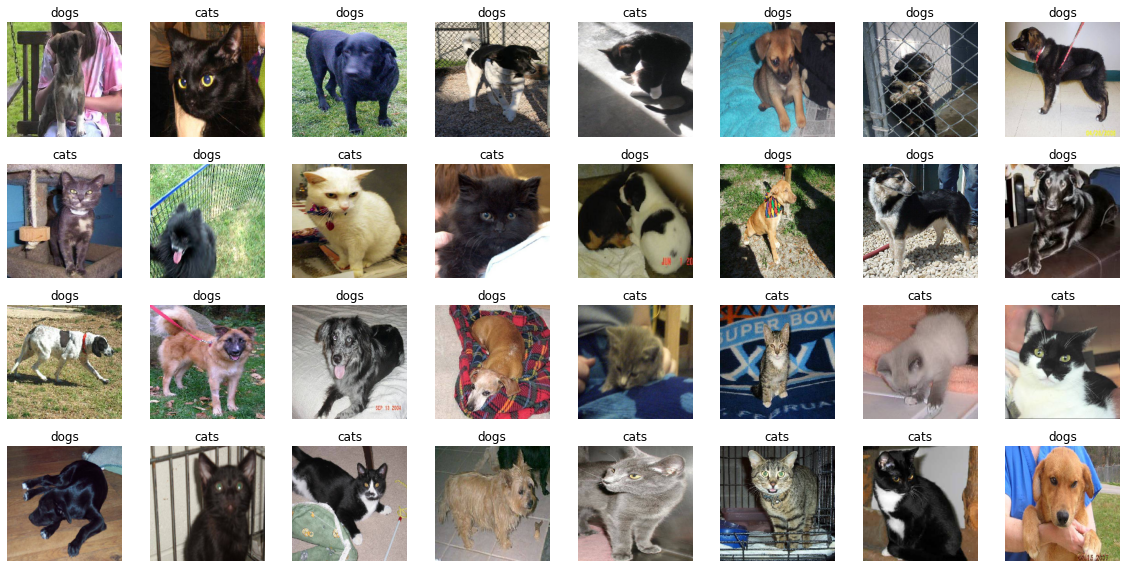

In [63]:
#샘플 이미지 출력
class_labels = ['cats','dogs']
batch = next(train_gen)
images, labels = batch[0], batch[1]

plt.figure(figsize=(16,8))
for i in range(32):

    ax = plt.subplot(4, 8, i+1)
    plt.imshow(images[i])
    plt.title(class_labels[labels[i].astype(np.int)])
    plt.axis('off')

plt.tight_layout()
plt.show()

#### 5-2-3 모델 훈련

In [65]:
#Sequential API를 사용하여 샘플 모델 생성

def build_model():

    model = tf.keras.Sequential([

        #Convolution 층
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),

        #Classifier 출력층
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')        
    ])

    return model

model = build_model()

In [67]:
#모델 컴파일
model.compile(optimizer=tf.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

#모델 훈련
history = model.fit(train_gen, validation_data=valid_gen, epochs=5)

Epoch 1/5
251/251 [==============================] - 1241s 5s/step - loss: 2.0463 - accuracy: 0.5785 - val_loss: 0.6541 - val_accuracy: 0.5783
Epoch 2/5
251/251 [==============================] - 1105s 4s/step - loss: 0.6393 - accuracy: 0.6274 - val_loss: 0.6021 - val_accuracy: 0.6678
Epoch 3/5
251/251 [==============================] - 1106s 4s/step - loss: 0.6200 - accuracy: 0.6572 - val_loss: 0.5843 - val_accuracy: 0.6925
Epoch 4/5
251/251 [==============================] - 1105s 4s/step - loss: 0.5982 - accuracy: 0.6683 - val_loss: 0.5990 - val_accuracy: 0.6708
Epoch 5/5
251/251 [==============================] - 1099s 4s/step - loss: 0.5834 - accuracy: 0.6858 - val_loss: 0.5524 - val_accuracy: 0.7084


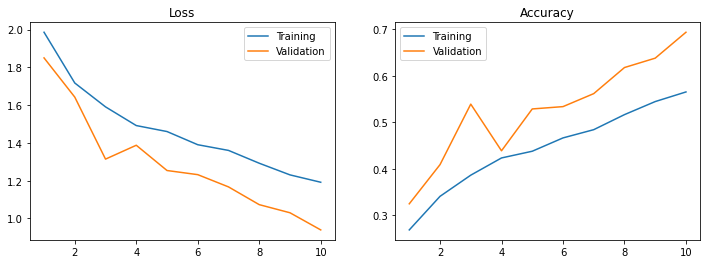

In [75]:
#손실함수, 정확도 그래프 그리기
plot_loss_acc(aug_history, 10)

#### 5-2-4 데이터 증강
- `ImageDataGenerator`를 사용하면 다양한 데이터 증강 기법을 클래스 함수의 매개변수 속성으로 지정할 수 있어서 편리하다는 장점이 있음

In [ ]:
#이미지 데이터 제너레이터 정의 (Augmentation 적용)
image_gen_aug = ImageDataGenerator(rescale=1/255.,
                                   horizontal_flip=True, #좌우 방향
                                   rotation_range=30, #회전 최대 각도
                                   shear_range=0.15, #반시계 방향으로 밀리도록 변형
                                   zoom_range=0.3) #줌으로 확대

#flow_from_directory 함수로 폴더에서 이미지 가져와서 제너레이터 객체러 정리
train_gen_aug = image_gen_aug.flow_from_directory(train_dir,
                                                  batch_size=32,
                                                  target_size=(224,224),
                                                  classes=['cats','dogs'],
                                                  class_mode='binary',
                                                  seed=2020)

valid_gen_aug = image_gen_aug.flow_from_directory(valid_dir,
                                                  batch_size=32,
                                                  target_size=(224,224),
                                                  classes=['cats','dogs'],
                                                  class_mode='binary',
                                                  seed=2020)

#모델 생성
model_aug = build_model()

#모델 컴파일
model_aug.compile(optimizer=tf.optimizers.Adam(lr=0.001),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

#모델 훈련
history_aug = model_aug.fit(train_gen_aug, validation_data=valid_gen_aug, epochs=5)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.
Epoch 1/5
169/251 [===================>..........] - ETA: 6:12 - loss: 2.6549 - accuracy: 0.5213

In [ ]:
#손실함수, 정확도 그래프 그리기
plot_loss_acc(aug_history, 10)